adies and gentlemen, welcome aboard AI Airline!

 Please fasten your seatbelts before reading the code.

 To prepare for what you're about to experience, we invite you to find a moment of quiet and focus. The code you're about to see is truly mind-blowing!

**Question 2**

**Section a**

For training a neural network model, a crucial aspect is deciding on a validation strategy that effectively assesses the model's performance while ensuring generalization to unseen data. Given the nature of the data and the insights gained from its curation and partitioning, a time-based separation strategy combined with stratification emerges as an elegant choice.

The data, comprising nearly 50,248 files, exhibits characteristics of time series data, where temporal relationships play a significant role. As such, preserving the temporal order of observations is paramount to effectively train and validate the model. The data is partitioned into files, each containing sequential observations over time.

The time-based separation strategy involves allocating 80% of the files for training and 20% for validation (changable), while maintaining the temporal sequence of observations within each file. This approach ensures that the model learns from past observations during training and generalizes to future ones during validation, mirroring real-world scenarios where predictions are made based on historical data.

Moreover, incorporating stratification into the validation process helps address class imbalances within the data (Remember that the data wasn't fully homogeneous as explained in data_analysis file). By ensuring that both the training and validation sets maintain proportional representation of each class, stratification enhances the robustness and reliability of the model's performance evaluation.

In conclusion, leveraging a time-based separation strategy with stratification for validation aligns well with the characteristics of the data and the objectives of the modeling task. This approach not only preserves temporal relationships but also addresses class imbalances, ultimately leading to a more robust and accurate neural network model.

Another important consideration, When partitioning the data into training and validation sets, the goal is to maintain the proportion of type 1 and type 2 files in both sets. This ensures that the model is trained and evaluated on a representative sample of each file type, preventing biases that may arise from unequal distribution.

For example, 80% of type 1 files and 80% of type 2 files should be allocated to the training set, while the remaining 20% of each file type should be allocated to the validation set. This maintains the relative proportions of type 1 and type 2 files in both sets, enabling fair evaluation of the model's performance across different file types. (I might consider also 80% for each activity...).

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import LSTM, Linear, Dropout, BatchNorm1d
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer, Callback
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from torchmetrics import Accuracy

from scipy.stats import skew, kurtosis, entropy
from scipy.signal import welch

In [56]:
# # Change csv file path if needed
# train_data = pd.read_csv('/Users/john-zaatri/Desktop/semester 7/סדנה מעשית בלמידה עמוקה/תרגילים/תרגיל 2/bgu-i-know-what-you-did-last-measurement-time/train.csv')

# # Path to the folder containing unlabeled data
# unlabeled_folder_path = '/Users/john-zaatri/Desktop/semester 7/סדנה מעשית בלמידה עמוקה/תרגילים/תרגיל 2/bgu-i-know-what-you-did-last-measurement-time/unlabeled/unlabeled/'

# Change csv file path if needed
train_data = pd.read_csv('/home/janz/model/data/train.csv')

# Path to the folder containing unlabeled data
unlabeled_folder_path = '/home/janz/model/data/unlabeled/unlabeled/'

# Dictionary to store DataFrames and additional information
data = {}

# Iterate through each row in train.csv
for index, row in train_data.iterrows():
    id_ = row['id']
    csv_filename = os.path.join(unlabeled_folder_path, f"{id_}.csv")
    df = pd.read_csv(csv_filename)
    userid = row['userid']
    sensor = row['sensor']
    body_part = row['body_part']
    side = row['side']
    sequence_length = row['sequence_length']
    activity = row['activity']
    data[id_] = {
        'dataframe': df,
        'userid': userid,
        'sensor': sensor,
        'body_part': body_part,
        'side': side,
        'sequence_length': sequence_length,
        'activity': activity
    }
# basically data is a dict, were each value is the id of the action (id column in train.csv), and it has the following structure (above) and the df is basically
# a type 1 file (which contain the columns "measurement type" or a type 2 file which doesn't has that column, and both of the files has 3 measurements
# columns (x, y and z))

In [57]:
# Somebody said preprocessing?, nice thing i done it before. note for me: use the code below when preprocessing the test data.
# Preprocessing for type 1 activity files
for id_, info in data.items():
    df = data[id_]['dataframe']
    if 'measurement type' in info['dataframe'].columns:
        # Remove measurements types from type 1 files and keep only the measurements of acceleration
        data[id_]['dataframe'].drop(df[df['measurement type'] != 'acceleration [m/s/s]'].index, inplace=True)

# Preprocessing for type 2 activity files
for id_, info in data.items():
    df = data[id_]['dataframe']
    if 'measurement type' not in info['dataframe'].columns:
        # Change column names to x, y, z
        df.rename(columns={'x [m]': 'x', 'y [m]': 'y', 'z [m]': 'z'}, inplace=True)
        # Multiply the measurements by 10
        df[['x', 'y', 'z']] *= 9.8


# # Shift the z-axis values in type 1 files by adding 20
# for id_, info in data.items():
#     if 'measurement type' in info['dataframe'].columns:
#         data[id_]['dataframe']['z'] += 20

# # Preprocessing for type 2 activity files
# # Define desired range
# desired_min = 0
# desired_max = 40
# for id_, info in data.items():
#     if 'measurement type' not in info['dataframe'].columns:
#         df = info['dataframe']
#         # Stretch the values distribution using Min-Max scaling
#         min_val = df['z'].min()
#         max_val = df['z'].max()
#         df['z'] = ((df['z'] - min_val) / (max_val - min_val)) * (desired_max - desired_min) + desired_min
#         # Clip values to ensure they fall within the desired range
#         df['z'] = np.clip(df['z'], desired_min, desired_max)


before splitting the data let's preprocess the test data

In [59]:
# All the code to reprocess the test data on a dict called unlabeled_data which it's keys = file name, and values are the dataframe
unlabeled_files = os.listdir(unlabeled_folder_path)
unlabeled_data = {}  # New variable to store unlabeled data
for filename in unlabeled_files:
    id_ = int(filename.split('.')[0])  # Extract ID from filename
    if id_ not in data.keys():
        # File not in train.csv, so we need to add it
        csv_filename = os.path.join(unlabeled_folder_path, filename)
        df = pd.read_csv(csv_filename)
        # df = cudf.read_csv(csv_filename)
        unlabeled_data[id_] = {'dataframe': df}

for id_, info in unlabeled_data.items():
    df = unlabeled_data[id_]['dataframe']
    if 'measurement type' in info['dataframe'].columns:
        # Remove measurements types from type 1 files and keep only the measurements of acceleration
        unlabeled_data[id_]['dataframe'].drop(df[df['measurement type'] != 'acceleration [m/s/s]'].index, inplace=True)

# Preprocessing for type 2 activity files
for id_, info in unlabeled_data.items():
    df = unlabeled_data[id_]['dataframe']
    if 'measurement type' not in info['dataframe'].columns:
        # Change column names to x, y, z
        df.rename(columns={'x [m]': 'x', 'y [m]': 'y', 'z [m]': 'z'}, inplace=True)
        # Multiply the measurements by 10
        df[['x', 'y', 'z']] *= 9.8

for id_, info in unlabeled_data.items():
    if 'measurement type' in info['dataframe']:
        info['dataframe'] = info['dataframe'].drop(columns=['measurement type'])

In [60]:
for id_, info in unlabeled_data.items():
    df = info['dataframe']
    if df.isnull().values.any():
        # Fill null values with the mean of the values in the previous and next rows
        for col in df.columns:
            # Iterate over each row
            for i in range(len(df)):
                if pd.isnull(df.loc[i, col]):  # Check if the value is null
                    # Fill null value with the mean of the previous and next rows
                    if i == 0:
                        df.loc[i, col] = df.loc[i + 1, col]
                    elif i == len(df) - 1:
                        df.loc[i, col] = df.loc[i - 1, col]
                    else:
                        df.loc[i, col] = (df.loc[i - 1, col] + df.loc[i + 1, col]) / 2

In [61]:
# Split the train data to 80% train, 20% validation
# Separate type 1 and type 2 data
type1_data = [data[id_] for id_ in data if 'measurement type' in data[id_]['dataframe'].columns]
type2_data = [data[id_] for id_ in data if 'measurement type' not in data[id_]['dataframe'].columns]

# Split type 1 data into train and validation
type1_train = []
type1_val = []
for activity in train_data['activity'].unique():
    activity_data = [d for d in type1_data if d['activity'] == activity]
    train_activity_data, val_activity_data = train_test_split(activity_data, test_size=0.2, random_state=42)
    type1_train.extend(train_activity_data)
    type1_val.extend(val_activity_data)

# Split type 2 data into train and validation
type2_train = []
type2_val = []
for activity in train_data['activity'].unique():
    activity_data = [d for d in type2_data if d['activity'] == activity]
    if len(activity_data) > 1:
        train_activity_data, val_activity_data = train_test_split(activity_data, test_size=0.2, random_state=42)
        type2_train.extend(train_activity_data)
        type2_val.extend(val_activity_data)

# Combine train and validation sets
train_set = type1_train + type2_train
val_set = type1_val + type2_val

# Since we finally done those steps, let's try to drop the column measurement type
# Drop the 'measurement type' column from dataframes in train_set (if it exists)
for sample in train_set:
    if 'measurement type' in sample['dataframe']:
        sample['dataframe'] = sample['dataframe'].drop(columns=['measurement type'])

# Drop the 'measurement type' column from dataframes in val_set (if it exists)
for sample in val_set:
    if 'measurement type' in sample['dataframe']:
        sample['dataframe'] = sample['dataframe'].drop(columns=['measurement type'])



**Section b**

In this section, we opted for a naïve baseline solution using class distribution, specifically by predicting the most frequent class for all instances in the dataset. 

We calculated the class distribution in the training data using a Counter to count the frequency of each class.
Then, we identified the most frequent class, which serves as our prediction for all instances in both the training and validation sets. (naive prediction)

why i chose this way?!?!: simple and easy to implement.
And serves as a baseline, it provides a basic benchmark for comparing the performance of more complex models. (oh i am excited, what next)

But why i feel a bit sad?!?!: This model lacks predictive power, By always predicting the most frequent class, the model may overlook important patterns and variations in the data. (but, it's ok, its naiiiiiive)

In [62]:
# Define X_train and y_train and X_val and y_val
# Extract features and labels for training set
X_train = []
y_train = []
for sample in train_set:
    X_train.append(sample['dataframe'])
    y_train.append(sample['activity'])

# Extract features and labels for validation set
X_val = []
y_val = []
for sample in val_set:
    X_val.append(sample['dataframe'])
    y_val.append(sample['activity'])

In [63]:
# X_train and X_val are both lists of dataframes (type 1 + 2)
# y_train and y_val are both lists of activities names

# Calculate class distribution in the entire training data (using Counter for lists)
from collections import Counter
class_counts = Counter(y_train)  # Create a Counter for frequency counting
sorted_class_counts = sorted(class_counts.items(), key=lambda item: item[1], reverse=True)
most_frequent_class = sorted_class_counts[0][0]  # Get the most frequent class

def class_distribution_prediction(sample):
    return most_frequent_class  # Always predict the most frequent class

# Calculate train and validation accuracy (using list indexing for y_train)
train_predictions = [class_distribution_prediction(sample) for sample in X_train]
train_accuracy = accuracy_score(y_train, train_predictions)

val_predictions = [class_distribution_prediction(sample) for sample in X_val]
val_accuracy = accuracy_score(y_val, val_predictions)

print("Train accuracy using class distribution:", train_accuracy)
print("Validation accuracy using class distribution:", val_accuracy)


Train accuracy using class distribution: 0.09110591280111487
Validation accuracy using class distribution: 0.09111685214626392


The output shows the accuracy achieved by the naïve baseline solution using class distribution.
Both the training and validation accuracies are approximately 0.09, indicating that the model correctly predicts the most frequent class for around 9% of instances.
This low accuracy underscores the limitations of the approach and highlights the need for more sophisticated modeling techniques to improve predictive performance.

Let's make our hands dirty with some ML DL implementations. --> next section

**Section c**

note for me: 

train_set: has 80% of each activity and 80% of each file type for training. {{dataframe, userid, sensor, body_part, side, sequence_length, activity}, ...}

val_set: has 20% of each activity and 20% of each file type for training. {{dataframe, userid, sensor, body_part, side, sequence_length, activity}, ...}

Now, let's feature extraction from training and validation. (Extracting features from all data may increase the risk of data leakage, especially because i perform preprocessing steps)

The function extract_features_from_accelerometer_data computes various statistical features from accelerometer data without delving into the specific interpretations or significance of each statistic. These features include measures like mean, standard deviation, root mean square, skewness, kurtosis, peak-to-peak amplitude, autocorrelation coefficients, FFT coefficients, entropy, median, interquartile range (IQR), variance, coefficient of variation (CV), root mean square deviation (RMSD), and mean absolute deviation (MAD). In the context of time series data, statistics like autocorrelation coefficients, FFT coefficients, and features related to variation (such as standard deviation, variance, and MAD) are particularly important as they capture temporal dependencies, periodic patterns, and overall variability in the data.

In [64]:
def extract_features_from_accelerometer_data(df):
    features = []
    
    # Mean
    mean_values = df.mean()
    features.extend(mean_values.tolist())
    
    # Standard Deviation
    std_values = df.std()
    features.extend(std_values.tolist())
    
    # Root Mean Square (RMS)
    rms_value = np.sqrt(np.mean(df**2))
    features.extend(rms_value.tolist())
    
    # Skewness
    skewness_values = df.apply(skew)
    features.extend(skewness_values.tolist())
    
    # Kurtosis
    kurtosis_values = df.apply(kurtosis)
    features.extend(kurtosis_values.tolist())
    
    # Peak-to-Peak Amplitude
    peak_to_peak_values = df.apply(lambda x: x.max() - x.min())
    features.extend(peak_to_peak_values.tolist())
    
    # Autocorrelation Coefficients
    autocorr = df.apply(lambda x: x.autocorr())
    features.append(autocorr.mean())
    features.append(autocorr.std())
    
    # Fast Fourier Transform (FFT) Coefficients
    fft_coeffs = np.abs(np.fft.fft(df))
    features.extend(np.mean(fft_coeffs, axis=0).tolist())
    features.extend(np.std(fft_coeffs, axis=0).tolist())
    
    # Entropy
    # entropy_values = df.apply(lambda x: entropy(np.histogram(x[~np.isnan(x)], bins='auto')[0]))
    # features.extend(entropy_values.tolist())


    
    # Additional Statistical Features i have to test (include improvment for the previous)
    # Median
    median_values = df.median()
    features.extend(median_values.tolist())
    
    # Interquartile Range (IQR)
    iqr_values = df.quantile(0.75) - df.quantile(0.25)
    features.extend(iqr_values.tolist())
    
    # # Minimum
    # min_values = df.min()
    # # features.extend(min_values.tolist())
    
    # # Maximum
    # max_values = df.max()
    # # features.extend(max_values.tolist())
    
    # # Range
    # range_values = max_values - min_values
    # features.extend(range_values.tolist())
    
    # Variance
    variance_values = df.var()
    features.extend(variance_values.tolist())
    
    # Coefficient of Variation (CV)
    cv_values = std_values / mean_values
    features.extend(cv_values.tolist())
    
    # Root Mean Square Deviation (RMSD)
    rmsd_values = np.sqrt(np.mean((df - mean_values)**2))
    # features.append(np.nan_to_num(rmsd_values))
    for value in np.nan_to_num(rmsd_values):
        features.append(value)
    
    # Mean Absolute Deviation (MAD)
    med_abs_dev_values = np.median(np.abs(df - np.median(df)))
    # features.extend(med_abs_dev_values.tolist())
    features.append(np.nan_to_num(med_abs_dev_values))
    
    # # Sum
    # sum_values = df.sum()
    # features.extend(sum_values.tolist())

    
    # Concatenate features into a single feature vector
    feature_vector = np.array(features).flatten()

    return feature_vector

The extract_features function takes a dataset consisting of a list of dictionaries, each containing sample information, and extracts features from the accelerometer measurements stored in the 'dataframe' key of each dictionary. It returns two lists: 'X', containing the feature vectors, and 'y', containing the corresponding labels. Inside the function, it iterates over each sample in the dataset, extracts features using the extract_features_from_accelerometer_data function, appends the features to 'X', and appends the label to 'y'. Finally, it returns the lists of feature vectors and labels for both the training and validation sets.

In [65]:
def extract_features(dataset):
    X = []  # Feature vectors
    y = []  # Labels

    for sample in dataset:
        # Extract relevant features from the accelerometer measurements
        features = extract_features_from_accelerometer_data(sample['dataframe'])

        # Append features to X
        X.append(features)

        # Append label to y
        y.append(sample['activity'])

    return X, y

# Extract features from the training set
X_train, y_train = extract_features(train_set)

# Extract features from the validation set
X_val, y_val = extract_features(val_set)


Here, a Random Forest classifier is initialized with 100 trees and a random state of 42. To prepare the input data for the classifier, the nested NumPy arrays in `X_train` and `X_val` are flattened using a custom `flatten` function. Then, the flattened arrays are converted to PyTorch tensors and moved to the GPU for faster computation. The string labels in `y_train` and `y_val` are encoded using `LabelEncoder`, and the encoded labels are converted to PyTorch tensors. The Random Forest model is trained using the training data, and predictions are made for both the training and validation sets. Finally, the accuracy scores for both sets are calculated using the `accuracy_score` function and printed out.

In [66]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Flatten the nested NumPy arrays in X_train
def flatten(arr):
    flat_arr = []
    for item in arr:
        if isinstance(item, np.ndarray):
            flat_arr.extend(flatten(item))
        else:
            flat_arr.append(item)
    return flat_arr

X_train_flat = [flatten(sample) if isinstance(sample, np.ndarray) else sample for sample in X_train]
X_val_flat = [flatten(sample) if isinstance(sample, np.ndarray) else sample for sample in X_val]


# Convert X_train_flat to a PyTorch tensor and move it to GPU
X_train_tensor = torch.tensor(X_train_flat, dtype=torch.float32).cuda()
X_val_tensor = torch.tensor(X_val_flat, dtype=torch.float32).cuda()

# Encode the string labels in y_train
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)

# Convert y_train_encoded to a PyTorch tensor
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long).cuda()

# Train the Random Forest model
rf_classifier.fit(X_train_tensor.cpu().numpy(), y_train_tensor.cpu().numpy())

# Predict labels for the training set
train_predictions_rf = rf_classifier.predict(X_train_tensor.cpu().numpy())

# Calculate accuracy score on the training set
train_accuracy_rf = accuracy_score(y_train_encoded, train_predictions_rf)

# Predict labels for the validation set
val_predictions_rf = rf_classifier.predict(X_val_tensor.cpu().numpy())

# Calculate accuracy score on the validation set
val_accuracy_rf = accuracy_score(y_val_encoded, val_predictions_rf)

print("Train Accuracy (Random Forest):", train_accuracy_rf)
print("Validation Accuracy (Random Forest):", val_accuracy_rf)

Train Accuracy (Random Forest): 1.0
Validation Accuracy (Random Forest): 0.9708863275039745


Training accuracy of 1.0 means the model memorized the training data perfectly. This is great, but it could also mean it's overfitting, like remembering faces in photos instead of learning what makes a face (Am i a superhero?). The validation accuracy of 0.971 is good news, It shows the model still works well on new data it hasn't seen before. Overall, the model seems to be doing well, but there's a chance it's a bit too focused on the specific examples it trained on.

Overall, these results suggest that the Random Forest model is performing well, but there might be some degree of overfitting to the training data.

First let's extract the features for the test data:

In [ ]:
# Extract features from the unlabeled data
unlabeled_features = {}
for id_, info in unlabeled_data.items():
    features = extract_features_from_accelerometer_data(info['dataframe'])
    unlabeled_features[id_] = features

Next, let's use the trained Random Forest classifier to make predictions on these unlabeled feature vectors, obtaining class probabilities. These probabilities are organized into a DataFrame with activity names as columns and sample IDs as indices. Finally, the predictions are saved to a CSV file named 'predictions_randomforest.csv'.

In [ ]:
# Extract feature vectors from the unlabeled features dictionary
unlabeled_feature_vectors = []
for features in unlabeled_features.values():
    flat_features = []
    for item in features:
        if isinstance(item, np.ndarray):
            flat_features.extend(item)
        else:
            flat_features.append(item)
    unlabeled_feature_vectors.append(flat_features)

# Convert feature vectors to a NumPy array and then to a tensor
unlabeled_features_np = np.array(unlabeled_feature_vectors, dtype=np.float32)
unlabeled_features_tensor = torch.tensor(unlabeled_features_np).cuda()

# Make predictions using the trained Random Forest classifier
unlabeled_probabilities_numpy = rf_classifier.predict_proba(unlabeled_features_tensor.cpu().numpy())

activity_names = label_encoder.inverse_transform(rf_classifier.classes_)

# Organize the probabilities into a DataFrame
probabilities_df = pd.DataFrame(unlabeled_probabilities_numpy, index=list(unlabeled_features.keys()), columns=activity_names)

# Sort the DataFrame by index (ID)
probabilities_df = probabilities_df.sort_index()

# Save the predictions to a CSV file
probabilities_df.index.name = "sample_id"
probabilities_df.to_csv('/home/janz/model/predictions_randomforest.csv')


**Section d**

Let's start with 1D-CNN.

First of all we have to use label encoding to change the activities to numeric types. Then, conversion to PyTorch tensors --> creation of DataLoaders, in order to prepare the data for training and validation 

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 18

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit label encoder and transform labels (activities)
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Get the mapping between activity names and encoded numerical values
activity_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_encoded).to(device)
y_val_tensor = torch.tensor(y_val_encoded).to(device)

# Create DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_data = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_data, batch_size=batch_size)

/tmp/ipykernel_10432/3062554525.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)


I'll start by setting the random seed using torch.manual_seed(42) to ensure reproducibility of the results of PyTorch. This means that each time the code is run with the same random seed, the same sequence of random numbers will be generated. This is crucial for debugging, experimentation, and comparing different models or hyperparameters. (which is what i am going to do).

The 1D-CNN model defined in the code below is a convolutional neural network designed for processing one-dimensional sequential data, which is ours, time-series and sensor data. The model architecture consists of three convolutional layers (conv1, conv2, and conv3) followed by ReLU activation functions to introduce non-linearity. Max-pooling layers (pool) are used to down-sample the feature maps, reducing their spatial dimensions. Dropout regularization (dropout) is applied to prevent overfitting by randomly setting a fraction of the input units to zero during training. Finally, two fully connected layers (fc1 and fc2) are employed to perform classification, with the last layer producing output logits for each class.

In each nueral network project, it is important to address the use of hyperparameters: In this case, the learning rate, batch size, number of epochs, and hidden layer size are crucial parameters. A learning rate of 0.001 is commonly used as it strikes a balance between achieving reasonable convergence without causing divergence. The batch size, set to 18, determines the number of training examples processed in each iteration, balancing computational efficiency and memory requirements. With 100 epochs, the model iterates through the entire training dataset this number of times, affecting convergence and generalization. These hyperparameters need careful tuning to achieve optimal performance and prevent issues like underfitting or overfitting. Experimentation and tuning are essential to find the right configuration for the specific dataset and model architecture.

In [68]:
# Set random seed for PyTorch's random number generator
torch.manual_seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Define hyperparameters
input_size = 42  # Size of feature vector
num_classes = 18  # Number of unique activities
num_epochs = 100
learning_rate = 0.001 # 0.001

class CNN1D(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # self.batch_norm1 = nn.BatchNorm1d(32)  # Batch normalization after conv1
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # self.batch_norm2 = nn.BatchNorm1d(64)  # Batch normalization after conv2
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        # self.batch_norm3 = nn.BatchNorm1d(128)  # Batch normalization after conv2
        # self.relu3 = nn.ReLU()
        # self.pool3 = nn.MaxPool1d(kernel_size=2)
        
        self.fc = nn.Linear(64 * (input_size // 4), num_classes)  # Adjusted number of neurons
        # self.fc1 = nn.Linear(128 * (input_size // 8), 256)  # Added fully connected layer
        # self.fc2 = nn.Linear(256, num_classes)  # Output layer
        
        # self.dropout = nn.Dropout(0.5)  # Adding dropout

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # x = self.conv3(x)
        # x = self.batch_norm3(x)
        # x = self.relu3(x)
        # x = self.pool3(x)
        
        x = torch.flatten(x, 1)
        # x = self.dropout(x)  # Applying dropout
        x = self.fc(x)
        # x = torch.flatten(x, 1)
        # x = F.relu(self.fc1(x))  # Apply ReLU after the first fully connected layer
        # x = self.dropout(x)  # Applying dropout
        # x = self.fc2(x)
        return x

# Initialize the model
model = CNN1D(input_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)    

This code defines a training loop for a neural network model. It iterates over a specified number of epochs, performing training and validation steps in each epoch. Within each epoch, it trains the model on the training data, computes the training loss and accuracy, and then evaluates the model on the validation data to compute the validation loss and accuracy. The training and validation losses along with the accuracies are recorded for each epoch, and the progress is printed out after each epoch, showing the training and validation loss as well as the training and validation accuracy.

In [69]:
train_losses = []  # List to store training losses
val_losses = []    # List to store validation losses
train_accuracies = []  # List to store training accuracies
val_accuracies = []    # List to store validation accuracies

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)  # Record training loss for this epoch
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)  # Record training accuracy for this epoch
    
    # Compute validation loss and accuracy
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)  # Record validation loss for this epoch
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)  # Record validation accuracy for this epoch
    
    print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}, Training Accuracy: {train_accuracy:.2%}, Validation Accuracy: {val_accuracy:.2%}")


Epoch [1/100], Training Loss: 2.1325, Validation Loss: 1.8484, Training Accuracy: 46.03%, Validation Accuracy: 52.04%
Epoch [2/100], Training Loss: 1.4811, Validation Loss: 1.7339, Training Accuracy: 56.10%, Validation Accuracy: 58.03%
Epoch [3/100], Training Loss: 1.4422, Validation Loss: 2.0029, Training Accuracy: 60.67%, Validation Accuracy: 63.00%
Epoch [4/100], Training Loss: 1.5936, Validation Loss: 1.5958, Training Accuracy: 64.02%, Validation Accuracy: 63.17%
Epoch [5/100], Training Loss: 1.4412, Validation Loss: 2.1043, Training Accuracy: 66.14%, Validation Accuracy: 66.94%
Epoch [6/100], Training Loss: 1.3245, Validation Loss: 1.6389, Training Accuracy: 67.72%, Validation Accuracy: 67.53%
Epoch [7/100], Training Loss: 1.1459, Validation Loss: 1.7909, Training Accuracy: 69.18%, Validation Accuracy: 70.46%
Epoch [8/100], Training Loss: 1.5134, Validation Loss: 2.4803, Training Accuracy: 71.15%, Validation Accuracy: 70.14%
Epoch [9/100], Training Loss: 0.9434, Validation Loss: 1

The following two cells evaluate the model's accuracy on both the training and validation data. First, they set the model to evaluation mode and iterate through the respective data loaders. Within each iteration, the model predicts the output labels based on the input data. Then, it compares these predictions to the actual labels to determine the number of correct predictions. Finally, it computes the percentage of correct predictions over the total number of samples in each dataset and prints out the accuracy on both the training and validation sets as percentages.

In [70]:
# Evaluation on training data
model.eval()
with torch.no_grad():
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

print(f"Accuracy on training set: {(100 * correct_train / total_train):.2f}%")

Accuracy on training set: 89.44%


In [71]:
# Evaluation on validation data
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on validation set: {(100 * correct / total):.2f}%")

Accuracy on validation set: 83.99%


Here is a brief summary of the accuracy and explanations i done:

Preprocessing steps:

Scenario: All Preprocessing Steps:

Accuracy on training set: 83.80%
Accuracy on validation set: 79.45%

Explanation: This scenario involves performing all preprocessing steps, including multiplying Type 2 measurements by 9.8, stretching the z-axis values distribution in Type 2 files, and shifting the z-axis values in Type 1 files. While these preprocessing steps aim to enhance the quality and alignment of the data, the resulting accuracies suggest that the combined effect may not be as beneficial as expected. It's possible that certain preprocessing steps introduce noise or distortions that hinder the model's ability to generalize.

Scenario: Steps multiplying and shifting Only:

Accuracy on training set: 86.33%
Accuracy on validation set: 82.92%

Explanation: In this scenario, only the preprocessing steps of multiplying Type 2 measurements by 9.8 and shifting the z-axis values in Type 1 files are performed. This combination leads to a notable improvement in model performance compared to Scenario 1. The absence of stretching the z-axis values distribution in Type 2 files suggests that this particular normalization step may not be as crucial for improving classification accuracy.

Scenario: Step multiplying Only:

Accuracy on training set: 89.44%%
Accuracy on validation set: 83.99%%

Explanation: This scenario involves only multiplying Type 2 measurements by 9.8 as the preprocessing step. Surprisingly, this single preprocessing step results in the highest accuracies among all scenarios. It indicates that increasing the magnitude of Type 2 measurements plays a significant role in improving the model's ability to discriminate between different classes.

Scenario: No Preprocessing:

Accuracy on training set: 88.93%
Accuracy on validation set: 85.35%

Explanation: In this scenario, no preprocessing steps are applied to the data. Despite the absence of any normalization or alignment adjustments, the model still achieves relatively high accuracies. This suggests that the raw data may contain sufficiently informative features for classification, and additional preprocessing steps may not be necessary in this particular context.

The following plots illustrate the training and validation loss curves, as well as the training and validation accuracy curves over the epochs.

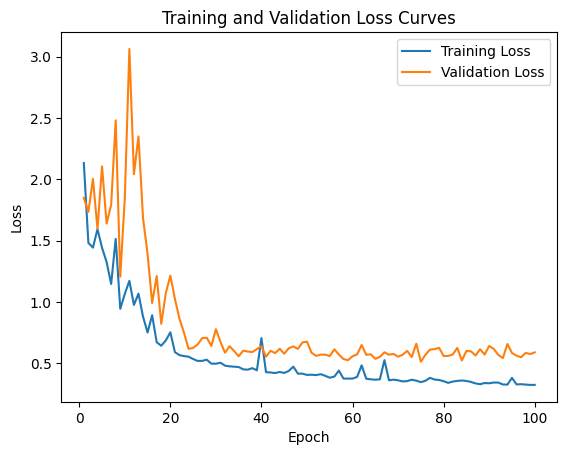

In [72]:
# Plotting the loss curves
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

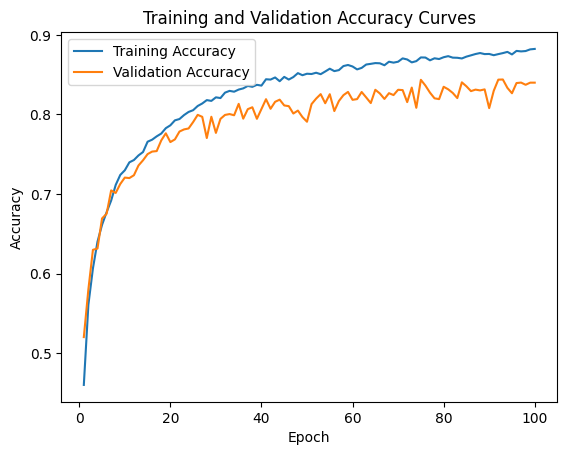

In [73]:
# Plot Training and Validation Accuracy Curves
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This function visualizes predictions made by the model on a given data loader, categorizing them into examples with high probability predictions and uncertain predictions based on a specified threshold. It prints a specified number of examples for each category, showing the predicted activity, true activity, and maximum probability. If the model's confidence is above the threshold, it's categorized as a high probability prediction, otherwise, it's considered uncertain. It ensures that it prints an equal number of examples for each category.

In [74]:
def visualize_predictions(model, dataloader, label_encoder, threshold=0.9, num_examples=6):
    # Set model to evaluation mode
    model.eval()

    # Initialize counters for examples with high probability and uncertain predictions
    high_prob_count = 0
    uncertain_count = 0

    # Keep track of encountered activities
    encountered_activities = set()

    # Iterate over the data loader
    for inputs, labels in dataloader:
        # Forward pass
        outputs = model(inputs)

        # Apply softmax to get probabilities
        probabilities = F.softmax(outputs, dim=1)

        # Get predicted labels
        predicted_labels = torch.argmax(probabilities, dim=1)

        # Iterate over each example
        for i in range(len(inputs)):
            # Convert predicted and true labels to activity names
            predicted_activity = label_encoder.inverse_transform([predicted_labels[i].item()])[0]
            true_activity = label_encoder.inverse_transform([labels[i].item()])[0]

            # Get the maximum probability
            max_prob = torch.max(probabilities[i]).item()

            # Check if the model's confidence is above or below the threshold
            if max_prob >= threshold and high_prob_count < num_examples // 2:
                # Check if the activity has already been encountered
                if predicted_activity not in encountered_activities:
                    print(f"Example {high_prob_count + 1} - High Probability Prediction:")
                    print(f"Predicted Activity: {predicted_activity}, True Activity: {true_activity}")
                    print(f"Max Probability: {max_prob:.2f}\n")
                    high_prob_count += 1
                    encountered_activities.add(predicted_activity)

            elif max_prob < threshold and uncertain_count < num_examples // 2:
                # Check if the activity has already been encountered
                if predicted_activity not in encountered_activities:
                    print(f"Example {uncertain_count + 1} - Uncertain Prediction:")
                    print(f"Predicted Activity: {predicted_activity}, True Activity: {true_activity}")
                    print(f"Max Probability: {max_prob:.2f}\n")
                    uncertain_count += 1
                    encountered_activities.add(predicted_activity)

            # Check if we've printed enough examples
            if high_prob_count >= num_examples // 2 and uncertain_count >= num_examples // 2:
                return

# Example usage
visualize_predictions(model, val_loader, label_encoder, threshold=0.9, num_examples=10)


Example 1 - High Probability Prediction:
Predicted Activity: stairs_up, True Activity: stairs_up
Max Probability: 1.00

Example 1 - Uncertain Prediction:
Predicted Activity: stairs_down, True Activity: stairs_up
Max Probability: 0.66

Example 2 - Uncertain Prediction:
Predicted Activity: walking_with_handbag, True Activity: stairs_up
Max Probability: 0.80

Example 2 - High Probability Prediction:
Predicted Activity: walking_with_hands_in_pockets, True Activity: walking_with_hands_in_pockets
Max Probability: 1.00

Example 3 - High Probability Prediction:
Predicted Activity: walking_with_object_underarm, True Activity: walking_with_hands_in_pockets
Max Probability: 0.92

Example 3 - Uncertain Prediction:
Predicted Activity: washing_plate, True Activity: walking_with_hands_in_pockets
Max Probability: 0.37

Example 4 - Uncertain Prediction:
Predicted Activity: washing_face_and_hands, True Activity: walking_with_hands_in_pockets
Max Probability: 0.32

Example 5 - Uncertain Prediction:
Predi

In the series of examples provided, each prediction outcome showcases the varying levels of certainty exhibited by the model in identifying specific activities. Instances labeled as "high probability predictions" indicate the model's strong confidence, correctly aligning with the true activity labels and often displaying maximum probabilities. Conversely, "uncertain predictions" reveal instances where the model's confidence wavers, resulting in incorrect predictions or lower probabilities, suggesting ambiguity in the data or model's understanding. These examples underscore the importance of scrutinizing prediction confidence, as it offers valuable insights into the model's reliability and performance across different activity recognition tasks, aiding in the refinement and optimization of machine learning algorithms for improved accuracy and robustness.

This code calculates and prints other relevant metrics including precision, recall, and F1-score using `sklearn.metrics.classification_report`. It first makes predictions on the training and validation data using the trained model. Then, it converts the predicted labels and true labels from tensors to numpy arrays. Finally, it prints the classification reports for both the training and validation data, specifying the target names using the `activity_mapping` dictionary keys.

In [75]:
# Calculate and print other relevant metrics (precision, recall, F1-score) using sklearn.metrics
from sklearn.metrics import classification_report

# Predictions on training data
train_predicted = model(X_train_tensor)
train_predicted_labels = torch.argmax(train_predicted, axis=1).cpu().numpy()
train_true_labels = torch.tensor(y_train_encoded).cpu().numpy()

# Predictions on validation data
val_predicted = model(X_val_tensor)
val_predicted_labels = torch.argmax(val_predicted, axis=1).cpu().numpy()
val_true_labels = torch.tensor(y_val_encoded).cpu().numpy()

# Classification report for training data
print("Classification Report for Training Data:")
print(classification_report(train_true_labels, train_predicted_labels, target_names=activity_mapping.keys()))

# Classification report for validation data
print("Classification Report for Validation Data:")
print(classification_report(val_true_labels, val_predicted_labels, target_names=activity_mapping.keys()))


Classification Report for Training Data:
                               precision    recall  f1-score   support

               brushing_teeth       0.94      0.97      0.96      1147
                         idle       0.94      0.91      0.92      2139
           preparing_sandwich       0.89      0.96      0.92      1792
                 reading_book       0.97      0.91      0.94      2005
                  stairs_down       0.98      1.00      0.99       924
                    stairs_up       1.00      0.99      0.99      1004
                       typing       0.94      0.98      0.96       959
                  using_phone       0.94      0.90      0.92      3450
         using_remote_control       0.90      0.97      0.94      2041
               walking_freely       0.89      0.81      0.85      3661
       walking_holding_a_tray       0.90      0.90      0.90      3552
         walking_with_handbag       0.78      0.87      0.83      3607
walking_with_hands_in_pockets      

TEST

This code snippet extracts features from the test data using the `extract_features_from_accelerometer_data` function, creates a DataLoader for the test data, predicts labels for the test data using the trained model, and saves the predicted probabilities for each activity to a CSV file. It iterates over batches of test data, makes predictions using the model, and then converts the predicted labels to a list. After that, it creates a DataFrame (`df_results`) to store the activity probabilities, with sample IDs as the index. Finally, it sorts the rows of the DataFrame by ID and saves it to a CSV file.

In [ ]:
# Extract features from test data
test_features = {}
for id_, data_info in unlabeled_data.items():
    inputs = data_info['dataframe']
    features = extract_features_from_accelerometer_data(inputs)
    test_features[id_] = features


# Create DataLoader for the test data
X_test_tensors = torch.tensor(list(test_features.values()), dtype=torch.float32).to(device)
test_data = TensorDataset(X_test_tensors)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
# Predict labels for test data
model.eval()
predictions = []
with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs[0].to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.tolist())

# Create DataFrame with activity probabilities
activities = label_encoder.classes_
activity_probs = model(X_test_tensors).softmax(dim=1).tolist()
df_results = pd.DataFrame(activity_probs, index=test_features.keys(), columns=activities)
df_results.index.name = 'sample_id'

# Sort rows by DataFrame ID
df_results.sort_index(inplace=True)

# Save DataFrame to CSV file
df_results.to_csv('/home/janz/model/predictions_cnn.csv')

**LSTM**

Yaaay, the main reason why we have assignment number 2.

Whirring, time-traveling, deep thought factories, nostalgia engines, brainy time capsules, memory foam for machines, thinking machines with a time machine twist. (lstm is powerfull and exciting)

Let's start with data preperation.

This code segment prepares the training and validation sets for an LSTM model. It iterates over the samples in the training and validation sets, extracts the accelerometer data (assuming it's stored as a DataFrame), and appends it to `X_train_lstm` and `X_val_lstm` respectively. It also extracts the activity labels and encodes them using `LabelEncoder`. The encoded labels are stored in `encoded_y_train_lstm` and `encoded_y_val_lstm`. Finally, it creates a mapping between activity names and their encoded numerical values.

In [ ]:
X_train_lstm = []
y_train_lstm = []
for sample in train_set:
    X_train_lstm.append(sample['dataframe'])
    y_train_lstm.append(sample['activity'])

X_val_lstm = []
y_val_lstm = []
for sample in val_set:
    X_val_lstm.append(sample['dataframe'])
    y_val_lstm.append(sample['activity'])

# Convert DataFrame to numpy array
X_train_lstm = [sample['dataframe'].values for sample in train_set]
X_val_lstm = [sample['dataframe'].values for sample in val_set]

# Encoding activity labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train_lstm)
encoded_y_train_lstm = label_encoder.transform(y_train_lstm)
encoded_y_val_lstm = label_encoder.transform(y_val_lstm)

# Get the mapping between activity names and encoded numerical values
activity_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

The choice of hyperparameters in this LSTM model is strategic and tailored to the characteristics of the dataset and the desired model complexity. The input size, set to 3, reflects the number of features in each input sequence (x, y, z). A hidden size of 32 units strikes a balance between model capacity and computational efficiency, allowing the LSTM to capture intricate patterns without excessive computational cost. Stacking 2 LSTM layers, specified by num_layers, enhances the model's ability to learn hierarchical representations of the data. The number of classes, obtained from the label encoder, determines the output size of the final fully connected layer, facilitating classification. A learning rate of 0.001 ensures smooth gradient descent optimization, while training over 100 epochs enables the model to sufficiently learn from the data. With a batch size of 256, the model processes a moderate number of examples in each iteration, balancing memory efficiency and gradient stability. The LSTMModel class encapsulates these hyperparameters, initializing an LSTM model with the specified configuration. In the forward method, input data undergoes LSTM processing, and the final hidden state is extracted for classification through a fully connected layer, yielding output logits. This holistic approach to hyperparameter selection and model architecture aims to optimize performance and generalization in the LSTM-based classification task.

In [43]:
# Hyperparameters
input_size = 3
hidden_size = 32
num_layers = 2
num_classes = len(label_encoder.classes_)
learning_rate = 0.001
num_epochs = 100
batch_size = 256

# Define the LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

#         # self.fc = nn.Linear(hidden_size, num_classes)
#         self.fc1 = nn.Linear(hidden_size, 64)
#         self.fc2 = nn.Linear(64, num_classes)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         out, _ = self.lstm(x, (h0, c0))

#         # out = self.fc(out[:, -1, :])
#         out = self.fc1(out[:, -1, :])
#         out = self.fc2(out)
#         return out
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(LSTMModel, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

#         self.fc = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
#         c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

#         out, _ = self.lstm(x, (h0, c0))
#         out = self.fc(out[:, -1, :])
#         return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # self.fc = nn.Linear(hidden_size, num_classes)
        self.fc1 = nn.Linear(hidden_size, 256)  # Increase number of neurons
        self.fc2 = nn.Linear(256, 128)  # Add another fully connected layer
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

        # self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))

        # out = self.fc(out[:, -1, :])

        out = out[:, -1, :]  # Extract the output of the last time step
        out = self.relu(self.fc1(out))  # Apply activation
        out = self.relu(self.fc2(out))  # Apply activation
        out = self.fc3(out)
        return out


The code defines a custom dataset class, `SensorDataset`, for organizing input features and labels. Sequences in the dataset are padded using PyTorch's `pad_sequence` function to ensure uniform length for efficient processing. While there's an alternative padding method provided (`pad_with_original_data`), more on the two methods will be explained later in the pretrain_model notebook. Data loaders are then created for both training and validation sets using the `SensorDataset` instances, facilitating batch processing during training and validation. The shuffle argument in the training data loader ensures randomization of samples for each epoch (as always).

In [44]:
# Define a custom dataset class
class SensorDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)

# fixed_length = 4000
# X_train_padded = pad_sequence([torch.tensor(seq[:fixed_length], dtype=torch.float) for seq in X_train_lstm], batch_first=True)
# X_val_padded = pad_sequence([torch.tensor(seq[:fixed_length], dtype=torch.float) for seq in X_val_lstm], batch_first=True)

def pad_with_original_data(seq, target_length, pad_position='last'):
    """
    Pad the sequence with a portion of the original data to reach the target length.
    """
  
    while(len(seq) < target_length):
        # print(len(seq))
        original_length = len(seq)
        padding_length = target_length - original_length
        if pad_position == 'first':
            padding = seq[:padding_length]  # Pad with the first portion of the sequence
            seq += padding
        elif pad_position == 'last':
            padding = seq[-padding_length:]  # Pad with the last portion of the sequence
            seq = np.concatenate((seq, padding), axis=0)
    return torch.tensor(seq, dtype=torch.float)  # Convert sequence to tensor

fixed_length = 4000

# Assuming X_train_lstm and X_val_lstm are lists of sequences
X_train_padded = pad_sequence([pad_with_original_data(seq, fixed_length, pad_position='last') for seq in X_train_lstm], batch_first=True)
X_val_padded = pad_sequence([pad_with_original_data(seq, fixed_length, pad_position='last') for seq in X_val_lstm], batch_first=True)


# Create DataLoader for training and validation
train_dataset = SensorDataset(X_train_padded, encoded_y_train_lstm)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = SensorDataset(X_val_padded, encoded_y_val_lstm)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [45]:
# Initialize the model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Now we train the model using PyTorch and monitors its performance on both training and validation datasets across multiple epochs. It iterates over each epoch, computes the loss and accuracy for each batch of data, and updates the model parameters accordingly. After each epoch, it evaluates the model on the validation dataset to assess its generalization performance. The training and validation losses, as well as the training and validation accuracies, are recorded for each epoch and can be visualized to track the training progress.

In [46]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_accuracy = correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

/tmp/ipykernel_10432/2189649866.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)


Epoch 1/100, Train Loss: 2.3174, Train Accuracy: 0.2012, Val Loss: 2.0314, Val Accuracy: 0.2757
Epoch 2/100, Train Loss: 1.9990, Train Accuracy: 0.2644, Val Loss: 1.9968, Val Accuracy: 0.2763
Epoch 3/100, Train Loss: 1.9806, Train Accuracy: 0.2719, Val Loss: 2.0040, Val Accuracy: 0.2712
Epoch 4/100, Train Loss: 1.9676, Train Accuracy: 0.2788, Val Loss: 1.9374, Val Accuracy: 0.2919
Epoch 5/100, Train Loss: 1.9244, Train Accuracy: 0.2899, Val Loss: 1.9026, Val Accuracy: 0.2836
Epoch 6/100, Train Loss: 1.8966, Train Accuracy: 0.2936, Val Loss: 1.8593, Val Accuracy: 0.3052
Epoch 7/100, Train Loss: 1.8140, Train Accuracy: 0.3216, Val Loss: 1.7782, Val Accuracy: 0.3321
Epoch 8/100, Train Loss: 1.7691, Train Accuracy: 0.3258, Val Loss: 1.7135, Val Accuracy: 0.3409
Epoch 9/100, Train Loss: 1.6923, Train Accuracy: 0.3440, Val Loss: 1.6531, Val Accuracy: 0.3586
Epoch 10/100, Train Loss: 1.7098, Train Accuracy: 0.3451, Val Loss: 1.7124, Val Accuracy: 0.3447
Epoch 11/100, Train Loss: 1.6679, Train

The following cells are same cells as the cnn ones, we caputre the same picture of results.

In [47]:
# Evaluation on training data
model.eval()
with torch.no_grad():
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

print(f"Accuracy on training set: {(100 * correct_train / total_train):.2f}%")

/tmp/ipykernel_10432/2189649866.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)


Accuracy on training set: 74.28%


In [48]:
# Evaluation on training data
model.eval()
with torch.no_grad():
    correct_train = 0
    total_train = 0
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

print(f"Accuracy on training set: {(100 * correct_train / total_train):.2f}%")

/tmp/ipykernel_10432/2189649866.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)


Accuracy on training set: 70.47%


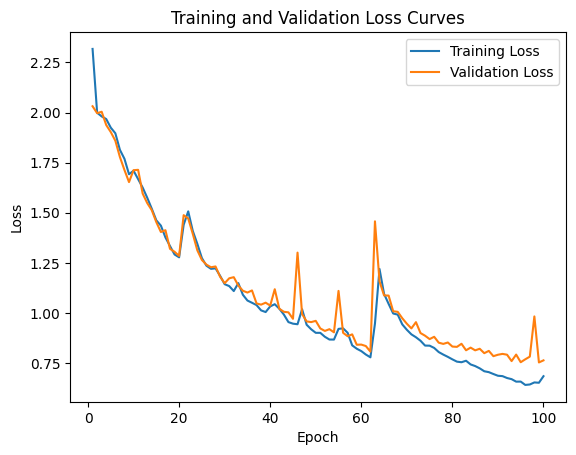

In [49]:
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

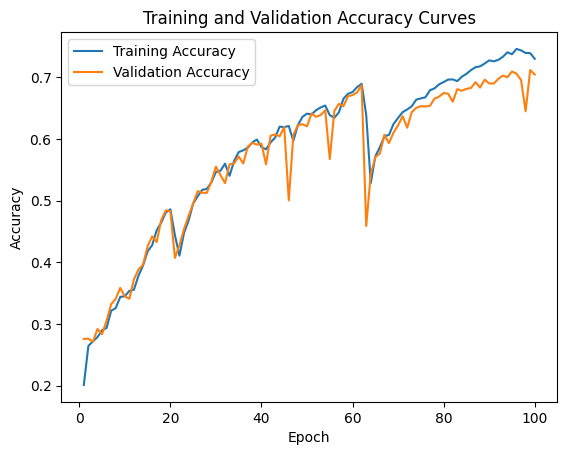

In [50]:
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
visualize_predictions(model, train_loader, label_encoder, threshold=0.9, num_examples=10)

Example 1 - Uncertain Prediction:
Predicted Activity: walking_holding_a_tray, True Activity: walking_with_handbag
Max Probability: 0.35

Example 1 - High Probability Prediction:
Predicted Activity: brushing_teeth, True Activity: brushing_teeth
Max Probability: 0.95

Example 2 - High Probability Prediction:
Predicted Activity: typing, True Activity: typing
Max Probability: 0.92

Example 2 - Uncertain Prediction:
Predicted Activity: washing_face_and_hands, True Activity: washing_face_and_hands
Max Probability: 0.79

Example 3 - Uncertain Prediction:
Predicted Activity: idle, True Activity: idle
Max Probability: 0.67

Example 4 - Uncertain Prediction:
Predicted Activity: walking_with_handbag, True Activity: using_phone
Max Probability: 0.44

Example 3 - High Probability Prediction:
Predicted Activity: washing_mug, True Activity: washing_mug
Max Probability: 0.99

Example 4 - High Probability Prediction:
Predicted Activity: preparing_sandwich, True Activity: preparing_sandwich
Max Probabil

/tmp/ipykernel_10432/2189649866.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)


The provided examples illustrate instances of both uncertain and high probability predictions made by the model across various activities. Uncertain predictions are characterized by lower probabilities and occasionally mismatched true activities, indicating the model's hesitancy or difficulty in accurately identifying certain activities. Conversely, high probability predictions exhibit stronger confidence, correctly aligning with the true activities and often displaying maximum probabilities. These examples highlight the importance of scrutinizing prediction confidence levels, as they offer valuable insights into the model's reliability and performance across different activity recognition tasks. By analyzing these predictions, researchers and practitioners can refine and optimize machine learning algorithms to improve accuracy and robustness in activity recognition systems.

In [55]:
from sklearn.metrics import classification_report

# Predictions on training data
train_predicted = []
train_true_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        train_predicted.extend(torch.argmax(outputs, axis=1).tolist())
        train_true_labels.extend(labels.tolist())

# Predictions on validation data
val_predicted = []
val_true_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        val_predicted.extend(torch.argmax(outputs, axis=1).tolist())
        val_true_labels.extend(labels.tolist())

# Classification report for training data
print("Classification Report for Training Data:")
print(classification_report(train_true_labels, train_predicted, target_names=activity_mapping.keys()))

# Classification report for validation data
print("Classification Report for Validation Data:")
print(classification_report(val_true_labels, val_predicted, target_names=activity_mapping.keys()))


/tmp/ipykernel_10432/2189649866.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.X[idx], dtype=torch.float).to(device), torch.tensor(self.y[idx]).to(device)


Classification Report for Training Data:
                               precision    recall  f1-score   support

               brushing_teeth       0.88      0.83      0.85      1147
                         idle       0.74      0.72      0.73      2139
           preparing_sandwich       0.75      0.69      0.72      1792
                 reading_book       0.81      0.80      0.81      2005
                  stairs_down       0.99      0.99      0.99       924
                    stairs_up       0.97      0.97      0.97      1004
                       typing       0.73      0.84      0.78       959
                  using_phone       0.74      0.64      0.68      3450
         using_remote_control       0.72      0.84      0.78      2041
               walking_freely       0.61      0.67      0.64      3661
       walking_holding_a_tray       0.81      0.86      0.84      3552
         walking_with_handbag       0.58      0.69      0.63      3607
walking_with_hands_in_pockets      

TEST

This code prepares the test data for prediction using a trained model. It pads the sequences to a fixed length and creates a DataLoader to iterate through batches of the test data. The model is then used to predict probabilities for each activity class on the test data. These probabilities are organized into a DataFrame along with the sample IDs, and the results are saved to a CSV file for further analysis or evaluation.

In [ ]:
X_test_lstm = [unlabeled_data[key]['dataframe'].values for key in sorted(unlabeled_data.keys())]

X_test_padded = pad_sequence([pad_with_original_data(seq, fixed_length, pad_position='last') for seq in X_test_lstm], batch_first=True)
# X_test_padded = pad_sequence([torch.tensor(seq[:fixed_length], dtype=torch.float) for seq in X_test_lstm], batch_first=True)

# Create DataLoader for test data
test_dataset = SensorDataset(X_test_padded, [0] * len(X_test_padded))  # Using dummy target class
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Get predicted probabilities for test data
model.eval()
probabilities = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Prepare data for CSV
sample_ids = sorted(unlabeled_data.keys())
activity_probabilities = pd.DataFrame(probabilities, columns=label_encoder.classes_)

# Combine sample IDs and probabilities
result_df = pd.DataFrame({'sample_id': sample_ids})
result_df = pd.concat([result_df, activity_probabilities], axis=1)

# Write probabilities to CSV
result_df.to_csv('/home/janz/model/predictions_sorted.csv', index=False)


Ladies and gentlemen, this is your captain speaking. We've begun our descent into the project. However, we've been placed into a holding pattern due to air traffic congestion. We appreciate your patience as we await clearance to land, meanwhile please take a look at the notebook "pretrain_model" on netflix.